# Reinforcement Learning Experiments

This notebook contains implementations and demonstrations of several reinforcement learning algorithms:

1. **Policy Iteration on Gridworld**: A complete implementation of policy iteration with animated visualization showing the convergence of value functions and policies in a 4x4 gridworld environment.

2. **CartPole with Gymnasium**: Basic environment interaction using the modern Gymnasium library (successor to OpenAI Gym) to explore the CartPole-v1 environment.

3. **MountainCar Q-Learning with RBF Features**: Advanced Q-learning implementation for the MountainCar environment using:
   - Radial Basis Function (RBF) feature approximation for continuous state spaces
   - Epsilon-greedy exploration with decay
   - Heuristic bootstrapping for faster initial learning
   - Animated visualization of the trained agent's performance

The notebook demonstrates both tabular RL methods (policy iteration) and function approximation techniques (RBF Q-learning) with comprehensive visualizations.

In [54]:
%matplotlib inline
import numpy as np, os, sys, time
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from IPython.display import HTML, display, Image as IPyImage
from PIL import Image
import gymnasium as gym
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler

mpl.rcParams["animation.html"] = "jshtml"
mpl.rcParams["animation.embed_limit"] = 200_000_000

env = gym.make("MountainCar-v0")
min_x = env.unwrapped.min_position
max_x = env.unwrapped.max_position
xs = np.linspace(min_x, max_x, 600)
track_h = np.array([env.unwrapped._height(x) for x in xs])
goal_x = env.unwrapped.goal_position
goal_y = env.unwrapped._height(goal_x)

car_img_path = r"C:\Users\ishmueli\OneDrive - CyberArk Ltd\University\RL\ISAR_IMG.png"
try:
    car_img = Image.open(car_img_path).convert("RGBA")
except:
    car_img = Image.fromarray(np.uint8(np.ones((40,80,4))*255)); car_img.putalpha(255)

def collect_states(policy="random", episodes=40, max_steps=1000):
    S = []
    for _ in range(episodes):
        s, _ = env.reset()
        for _ in range(max_steps):
            if policy == "random":
                a = env.action_space.sample()
            else:
                a = 2 if s[1] > 0 else 0
            s2, r, term, trunc, _ = env.step(a)
            S.append(s)
            s = s2
            if term or trunc: break
    return np.array(S)

S_fit = np.vstack([collect_states("random", 40), collect_states("heur", 40)])
scaler = StandardScaler().fit(S_fit)
rbfs = [RBFSampler(gamma=g, n_components=250, random_state=i+1) for i,g in enumerate([0.5,1.0,2.0,5.0])]
X_fit = scaler.transform(S_fit)
for r in rbfs: r.fit(X_fit)

def featurize(x):
    x2 = scaler.transform([x])[0]
    return np.concatenate([r.transform([x2])[0] for r in rbfs])

nA = env.action_space.n
nF = len(featurize(S_fit[0]))
W = np.full((nF, nA), 0.01)

def q_vals(s):
    phi = featurize(s)
    return phi @ W, phi

def greedy_act(s):
    qs, _ = q_vals(s)
    return int(np.argmax(qs))

def heuristic_act(s):
    return 2 if s[1] > 0 else 0

def train(episodes=12000, gamma=0.99, alpha=0.03, eps_start=1.0, eps_end=0.05, eps_decay=0.9995, heur_episodes=400, heur_prob=0.6, log_every=500):
    eps = eps_start
    rets = []
    t0 = time.time()
    for ep in range(1, episodes+1):
        s, _ = env.reset()
        done = False
        total = 0.0
        a_lr = alpha * (0.999 ** ep)
        while not done:
            use_heur = (ep <= heur_episodes) and (np.random.rand() < heur_prob)
            if use_heur:
                a = heuristic_act(s)
            else:
                if np.random.rand() < eps:
                    a = env.action_space.sample()
                else:
                    a = greedy_act(s)
            s2, r, term, trunc, _ = env.step(a)
            done = term or trunc
            qs, phi = q_vals(s)
            target = r if done else r + gamma * np.max(q_vals(s2)[0])
            W[:, a] += a_lr * (target - qs[a]) * phi
            s = s2
            total += r
        eps = max(eps_end, eps * eps_decay)
        rets.append(total)
        if ep % log_every == 0 or ep == 1:
            print(f"ep {ep}/{episodes} | return {total:.1f} | eps {eps:.3f} | time {time.time()-t0:.1f}s"); sys.stdout.flush()
    return rets

returns = train()

ep 1/12000 | return -162.0 | eps 1.000 | time 0.1s


KeyboardInterrupt: 


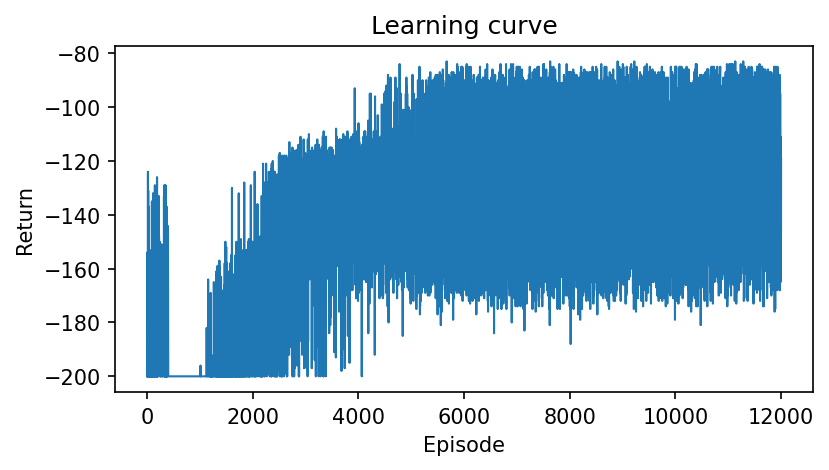

In [55]:
%matplotlib inline
import io, base64
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.transforms import Affine2D
from PIL import Image
from IPython.display import HTML, display

# --- sanity checks ---
if 'traj' not in globals() or len(traj) == 0:
    raise RuntimeError("No trajectory found. Run rollout() first.")
if 'env' not in globals():
    raise RuntimeError("No env found. Please ensure your MountainCar env exists as `env`.")
if 'returns' not in globals() or len(returns) == 0:
    raise RuntimeError("No `returns` found. Train first to collect episode returns.")

# ---------- 1) Learning curve PNG (left pane) ----------
fig_lc, ax_lc = plt.subplots(figsize=(6,3))
ax_lc.plot(returns, linewidth=1)
ax_lc.set_xlabel("Episode"); ax_lc.set_ylabel("Return")
ax_lc.set_title("Learning curve")
buf = io.BytesIO()
fig_lc.savefig(buf, format="png", dpi=150, bbox_inches="tight")
plt.close(fig_lc)
lc_png_b64 = base64.b64encode(buf.getvalue()).decode("ascii")

# ---------- 2) Animation (right pane), robust image movement ----------
# Load your car image
car_img = Image.open(car_img_path).convert("RGBA")
car_arr = np.asarray(car_img)

# Trajectory arrays
xs = np.array([s[0] for (s,_,_) in traj])
def height(x): return env.unwrapped._height(x)
ys = np.array([height(x) for x in xs])

# Figure for animation (tighter but keep x-axis ticks)
fig_anim, ax_anim = plt.subplots(figsize=(8,4))

# Use the full track horizontally, but trim vertical space
xmin, xmax = env.unwrapped.min_position, env.unwrapped.max_position
ax_anim.set_xlim(xmin, xmax)

curve_x = np.linspace(xmin, xmax, 600)
track_vals = np.array([height(x) for x in curve_x])

# Vertical limits: tighter than default, but not extreme
ax_anim.set_ylim(track_vals.min() - 0.05, track_vals.max() + 0.25)

# Draw the track
ax_anim.plot(curve_x, track_vals, "g-", lw=2)

# Goal marker
goal_x = env.unwrapped.goal_position
goal_y = height(goal_x)
ax_anim.plot([goal_x, goal_x], [goal_y, goal_y + 0.4], lw=2.5)
ax_anim.scatter([goal_x], [goal_y + 0.4], s=60)

# Keep x-axis ticks, remove y-axis ticks (cleaner)
ax_anim.set_yticks([])
for side in ("top", "right"):
    ax_anim.spines[side].set_visible(False)

# Shrink padding so the plot fills more of the canvas
fig_anim.subplots_adjust(left=0.01, right=0.98, bottom=0.12, top=0.95)

# Car size helpers (slightly bigger car, but not huge)
scale = 2.1
img_w = scale * 0.04 * (xmax - xmin)
img_h = scale * 0.10 * (ax_anim.get_ylim()[1] - ax_anim.get_ylim()[0])
yoff  = 0.02

def extent_for(x, y, w=img_w, h=img_h, yoff=yoff):
    return [x - w/2, x + w/2, y + yoff - h/2, y + yoff + h/2]

# Place image with imshow
img_artist = ax_anim.imshow(car_arr, extent=extent_for(xs[0], ys[0]), zorder=5)

# Tilt car with slope
def slope_angle_deg(x, dx=1e-3):
    dy = height(x + dx) - height(x - dx)
    return np.degrees(np.arctan(dy / (2*dx)))

title = ax_anim.text(0.02, 0.95, f"t=0  x={xs[0]:.3f}", transform=ax_anim.transAxes)

# Ensure we have at least 2 frames
frames_idx = np.arange(len(xs))
if len(frames_idx) < 2:
    frames_idx = np.array([0, 0])

def update(i):
    idx = int(frames_idx[i])
    x, y = xs[idx], ys[idx]
    img_artist.set_extent(extent_for(x, y))
    # tilt around center
    cx, cy = x, y + yoff
    tr = Affine2D().rotate_deg_around(cx, cy, slope_angle_deg(x)) + ax_anim.transData
    img_artist.set_transform(tr)
    title.set_text(f"t={idx}  x={x:.3f}")
    return (img_artist, title)

anim = FuncAnimation(fig_anim, update, frames=len(frames_idx), interval=40, blit=False)
anim_html = anim.to_jshtml()  # inline, plays in notebook
plt.close(fig_anim)  # prevent extra static figure

# ---------- 3) Side-by-side layout ----------
html = f"""
<div style="display:flex; gap:16px; align-items:flex-start; flex-wrap:wrap;">
  <div style="flex:1; min-width:320px; max-width:600px;">
    <h4 style="margin:0 0 8px 0; font-family:sans-serif;">Learning curve</h4>
    <img src="data:image/png;base64,{lc_png_b64}" style="max-width:100%; height:auto; border:1px solid #ddd; border-radius:6px;">
  </div>
  <div style="flex:1; min-width:320px; max-width:800px;">
    <h4 style="margin:0 0 8px 0; font-family:sans-serif;">MountainCar Animation</h4>
    {anim_html}
  </div>
</div>
"""
display(HTML(html))
